In [1]:
## Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import librosa
import IPython
import librosa.display

## Load MNIST dataset
train_df = pd.read_csv('./mnist_train.csv')
train_df_array = train_df.values
# train_df.head()
test_df = pd.read_csv('./mnist_test.csv')
test_df_array = test_df.values
test_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Create train and test arrays
X_train = train_df_array[:, 1:]
y_train = train_df_array[:, 0]
X_test = test_df_array[:, 1:]
y_test = test_df_array[:, 0]

# Normalize
def normalize(X):
    # X has the shape (examples * dimension)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)+1e-100
    return (X-mean)/std, mean, std

X_train, train_mean, train_std = normalize(X_train)
X_test, test_mean, test_std = normalize(X_test)
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


In [3]:
# Split the dataset into small batches (due to slow PLCA updates)
def K_duplicates(y, K):
    counts=[0 for k in range(10)]
    indices=[]
    for i in range(len(y)):
        if counts[y[i]]>=K : continue
        indices.append(i)
        counts[y[i]]+=1
    # print(counts)
    return indices

indices = K_duplicates(y_train, 100)
train_batch = X_train[indices, :].T
print(train_batch.shape)
corresponding_digits = y_train[indices]
print(corresponding_digits.shape)

(784, 1000)
(1000,)


In [4]:
## PLCA Initialize
def initialize(X, Y, Z):
    Px_z = np.random.uniform(low=0.1, high=0.9, size=(X, Z))
    Px_zbyy = np.random.uniform(low=0.1, high=0.9, size=(X, Y, Z))
    P_ybyz = np.random.uniform(low=0.1, high=0.9, size=(Z, Y))
    return Px_z, Px_zbyy, P_ybyz

## PLCA Normalize
def normalize_Px_z(X, Px_z) :
    for x in range(X): 
        Px_z[x, :] = Px_z[x, :]/sum(Px_z[x, :])
    return Px_z

def normalize_P_ybyz(Z, P_ybyz) :
    for z in range(Z): 
        P_ybyz[z, :] = P_ybyz[z, :]/sum(P_ybyz[z, :])
    return P_ybyz

def normalize_Px_zbyy(X, Y, Px_zbyy) :
    for x in range(X):
        for y in range(Y):
            Px_zbyy[x, y, :] = Px_zbyy[x, y, :]/sum(Px_zbyy[x, y, :])
    return Px_zbyy

In [5]:
## PLCA Update
def update_Px_zbyy(X, Z, Y, Px_zbyy, Px_z, P_ybyz) :
    for x in range(X):
        for y in range(Y):
            for z in range(Z):
                numerator = Px_z[x, z]*P_ybyz[z, y]
                denominator = np.dot(Px_z[x, :], P_ybyz[:, y])
                if(denominator==0) : Px_zbyy[x, y, z] = 0
                else : Px_zbyy[x, y, z] = numerator/denominator
    return Px_zbyy

def update_Px_z(X, Z, Px_z, Px_zbyy, Ixy) :
    for x in range(X):
        for z in range(Z):
            denominator=0
            for z1 in range(Z):
                if z1==z : numerator = np.dot(Ixy[:, x], Px_zbyy[x, :, z])
                denominator += np.dot(Ixy[:, x], Px_zbyy[x, :, z1])
            if(denominator) : Px_z[x, z] = numerator/denominator
            else : Px_z[x, z]=0
    return Px_z

def update_P_ybyz(Z, Y, P_ybyz, Px_zbyy, Ixy) :
    for z in range(Z):
        for y in range(Y):
            denominator=0
            for y1 in range(Y):
                if y1==y : numerator =  np.dot(Ixy[y, :], Px_zbyy[:, y, z])
                denominator += np.dot(Ixy[y1, :], Px_zbyy[:, y1, z])
            if(denominator) : P_ybyz[z, y] = numerator/denominator
            else :  P_ybyz[z, y]=0
    return P_ybyz

def update_all(Ixy, Z=3, iterations=1000, threshold=1e-3) :
    X = Ixy.shape[1]
    Y = Ixy.shape[0]    
    # initialize and normalize
    updated_Px_z, updated_Px_zbyy, updated_P_ybyz = initialize(X, Y, Z)
    updated_Px_z = normalize_Px_z(X, updated_Px_z)
    updated_P_ybyz = normalize_P_ybyz(Z, updated_P_ybyz)
    updated_Px_zbyy = normalize_Px_zbyy(X, Y, updated_Px_zbyy)
    # iterative updates
    for iteration in range(iterations) :
        # Create a soft copy of updates so that it doesn't gets changed after the updates
        # print(iteration)
        initial_Px_z = np.copy(updated_Px_z)
        initial_P_ybyz = np.copy(updated_P_ybyz)
        initial_Px_zbyy = np.copy(updated_Px_zbyy)
        # update
        updated_Px_zbyy = update_Px_zbyy(X, Z, Y, updated_Px_zbyy, updated_Px_z, updated_P_ybyz)
        updated_Px_z = update_Px_z(X, Z, updated_Px_z, updated_Px_zbyy, Ixy)
        updated_P_ybyz = update_P_ybyz(Z, Y, updated_P_ybyz, updated_Px_zbyy, Ixy)
        # break if L2 norm of ALL the matrices is lower than tht threshold
        if np.linalg.norm(updated_Px_zbyy-initial_Px_zbyy)>threshold : continue
        elif np.linalg.norm(updated_Px_z-initial_Px_z)>threshold : continue
        elif np.linalg.norm(updated_P_ybyz-initial_P_ybyz)>threshold : continue
        else : break
    return updated_Px_z, updated_Px_zbyy, updated_P_ybyz

In [6]:
# Train for 3D
Px_z, Px_zbyy, P_ybyz = update_all(train_batch, 3, 10, 1e-2)
print(Px_z.shape, P_ybyz.shape)
print(corresponding_digits.shape)

(1000, 3) (3, 784)
(1000,)


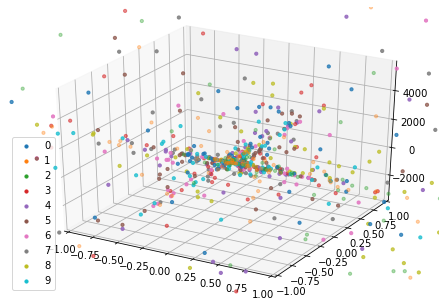

In [7]:
# Plot the low dimensional representations for 3D
figure = plt.figure()
axes = Axes3D(figure)
for digit in np.unique(corresponding_digits):
    index = np.where(corresponding_digits == digit)
    axes.scatter(Px_z[index][:, 0], Px_z[index][:, 1], Px_z[index][:, 2], label=digit, s=10)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
axes.legend()
plt.show()

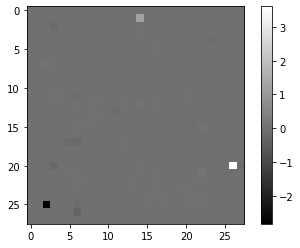

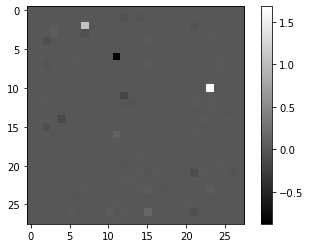

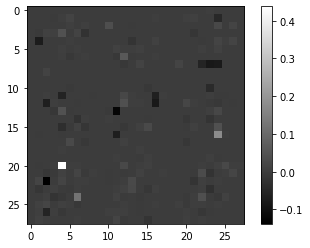

In [8]:
# Plot the basis vectors as images for 3D
sq_dim = int(np.sqrt(P_ybyz.shape[1]))
channels = P_ybyz.shape[0]
reshaped_basis = np.reshape(P_ybyz, (sq_dim, sq_dim, channels))
for k in range(P_ybyz.shape[0]):
    plt.imshow(reshaped_basis[:, :, k], cmap='gray')
    plt.colorbar()
    plt.show()

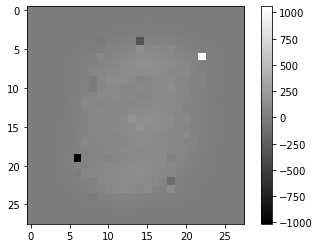

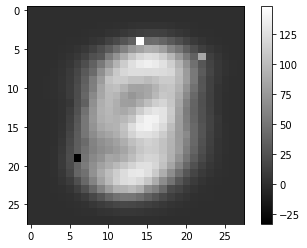

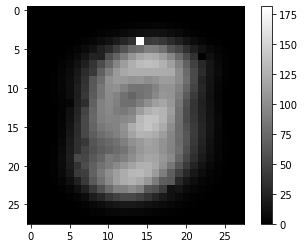

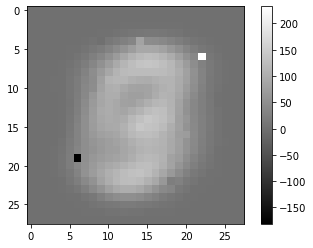

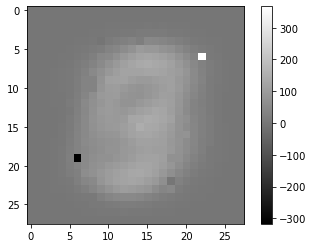

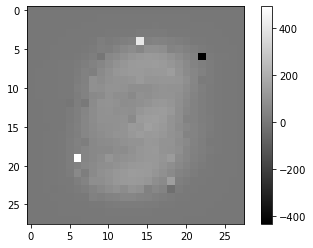

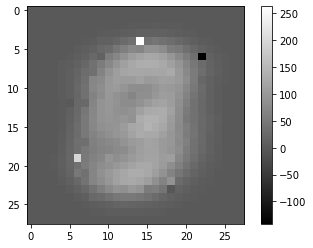

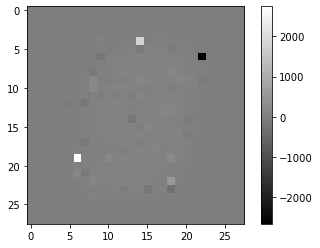

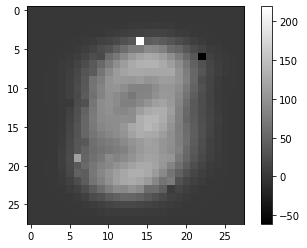

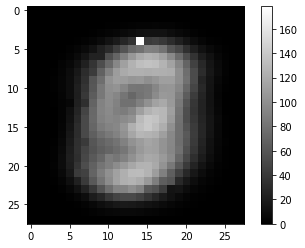

In [9]:
# Plot the reconstructed samples, one per image for 3D
indices = K_duplicates(corresponding_digits, 1)
for index in indices:
    Px_z_index = np.reshape(Px_z[index], [1]+list(Px_z[index].shape))
    reconstructed_vector = np.dot(Px_z_index, P_ybyz)
    unnormalized_vector = reconstructed_vector*(train_std+1e-100) + train_mean
    side_length = int(np.sqrt(P_ybyz.shape[1]))
    reconstructed_array = np.reshape(unnormalized_vector, (side_length, side_length))
    plt.imshow(reconstructed_array, cmap='gray')
    plt.colorbar()
    plt.show()   

In [10]:
# Train for 2D
Px_z, Px_zbyy, P_ybyz = update_all(train_batch, 2, 10, 1e-2)
print(Px_z.shape, P_ybyz.shape)
print(corresponding_digits.shape)

(1000, 2) (2, 784)
(1000,)


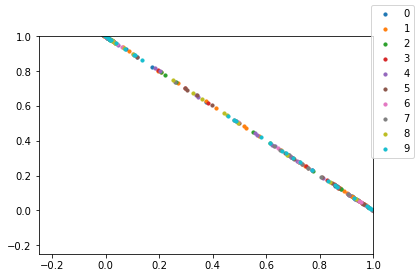

In [11]:
# Plot the low dimensional representations for 2D
figure = plt.figure()
for digit in np.unique(corresponding_digits):
    index = np.where(corresponding_digits == digit)
    plt.scatter(Px_z[index][:, 0], Px_z[index][:, 1], label=digit, s=10)
plt.xlim(-0.25, 1)
plt.ylim(-0.25, 1)
figure.legend()
plt.show()

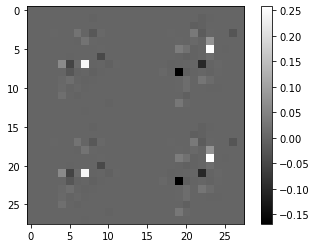

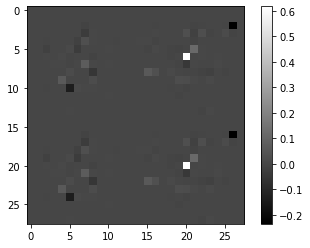

In [12]:
# Plot the basis vectors as images for 2D
sq_dim = int(np.sqrt(P_ybyz.shape[1]))
channels = P_ybyz.shape[0]
reshaped_basis = np.reshape(P_ybyz, (sq_dim, sq_dim, channels))
for k in range(P_ybyz.shape[0]):
    plt.imshow(reshaped_basis[:, :, k], cmap='gray')
    plt.colorbar()
    plt.show()

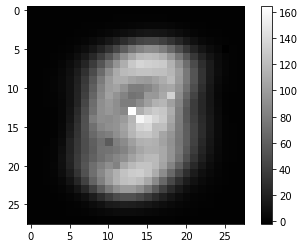

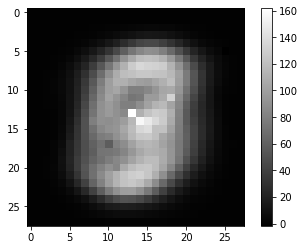

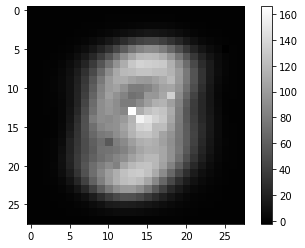

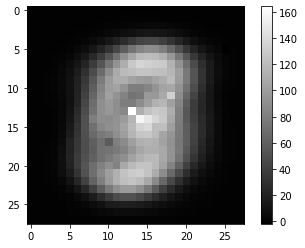

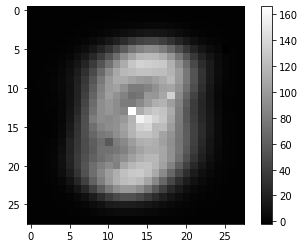

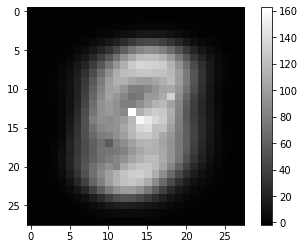

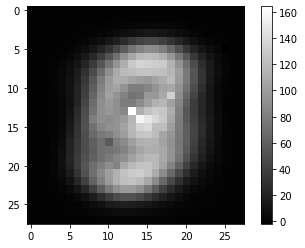

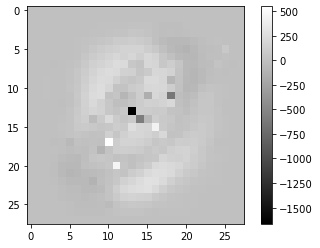

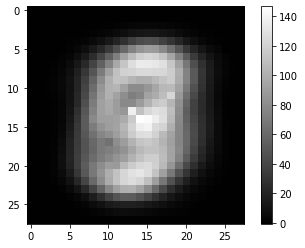

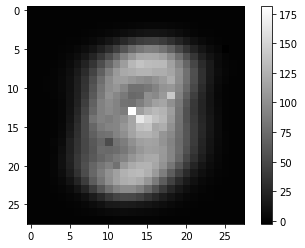

In [13]:
# Plot the reconstructed samples, one per image for 2D
indices = K_duplicates(corresponding_digits, 1)
for index in indices:
    Px_z_index = np.reshape(Px_z[index], [1]+list(Px_z[index].shape))
    reconstructed_vector = np.dot(Px_z_index, P_ybyz)
    unnormalized_vector = reconstructed_vector*(train_std+1e-100) + train_mean
    side_length = int(np.sqrt(P_ybyz.shape[1]))
    reconstructed_array = np.reshape(unnormalized_vector, (side_length, side_length))
    plt.imshow(reconstructed_array, cmap='gray')
    plt.colorbar()
    plt.show()   

In [22]:
## Create file path array, and separate
import os
train_file_path = './sounds_train/'
test_file_path = './sounds_test/'

def create_paths(file_path):
    close_paths = []
    music_paths = []
    speech_paths = []
    knock_paths = []
    background_paths = []
    for sound_name in os.listdir(file_path):
        if sound_name == '.DS_Store': continue
        elif 'Close' in sound_name : close_paths.append(file_path+sound_name)
        elif 'Music' in sound_name : music_paths.append(file_path+sound_name)
        elif 'Speech' in sound_name : speech_paths.append(file_path+sound_name)
        elif 'Knock' in sound_name : knock_paths.append(file_path+sound_name)
        elif 'Background' in sound_name : background_paths.append(file_path+sound_name)
    return np.array([close_paths, music_paths, speech_paths, knock_paths, background_paths])

train_paths = create_paths(train_file_path)
test_paths = create_paths(test_file_path)
print(train_paths[2][:5])

['./sounds_train/Speech_9.wav' './sounds_train/Speech_8.wav'
 './sounds_train/Speech_10.wav' './sounds_train/Speech_6.wav'
 './sounds_train/Speech_7.wav']


In [23]:
## Display a single sound from Close 
sound, sample_rate = librosa.load(train_paths[0][0])
IPython.display.Audio(data = sound, rate = sample_rate)

(706, 1003)


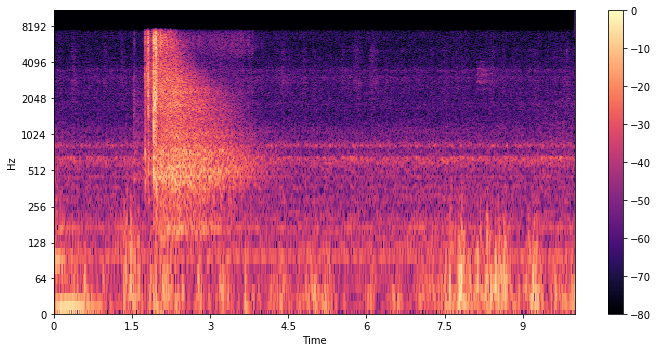

In [24]:
## Plot STFT of a single song for Close
def create_Vft(sound_path):
    sound, sample_rate = librosa.load(sound_path)
    window_size = int(0.064*sample_rate)
    hop_size = int(0.010*sample_rate)
    Stft = librosa.stft(sound, n_fft = window_size, hop_length=hop_size)
    Vft, phase = librosa.magphase(Stft)
    return Vft

Vft = create_Vft(train_paths[0][0])
print(Vft.shape)
# Plot STFT
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db(Vft,ref=np.max), x_axis='time', y_axis='log', 
                        sr=sample_rate, hop_length=220)
plt.colorbar()
plt.tight_layout()

In [25]:
## Create a joint Vft for two sounds
def create_merge_Vfts(sound_paths, number_of_sounds):
    merged_Vfts=[]
    for i in range(sound_paths.shape[0]):
        merged_sound_Vfts = []
        iteration=0
        random_indices = np.random.permutation(len(sound_paths[i]))[:number_of_sounds]
        for random_sound_index in random_indices :
            sound_Vft = create_Vft(sound_paths[i][random_sound_index])
            # Merge
            if iteration==0 : merged_sound_Vfts = sound_Vft
            else : merged_sound_Vfts = np.concatenate((merged_sound_Vfts, sound_Vft), axis=1)
            iteration+=1
        merged_Vfts.append(merged_sound_Vfts)
    return np.array(merged_Vfts)

# Define the number of components you want to use
components = 2
train_Vfts = create_merge_Vfts(train_paths, components)
print(train_Vfts.shape)

(5, 706, 2006)


In [26]:
## Create the dictionaries of different classes
def create_dictionaries(Vfts, components):   
    dicts=[]
    for i in range(Vfts.shape[0]):
        Pt_z, Pt_zbyf, P_fbyz = update_all(Vfts[i], Z=components, iterations=5, threshold=1e-2)
        dicts.append(P_fbyz)
    return np.array(dicts)

Dicts = create_dictionaries(train_Vfts, components)
print(Dicts.shape)

(5, 2, 706)


In [27]:
# Find the least squared weights for a given test_Vft using Dicts
def least_squared_weights(Dicts, test_Vft):
    # dictionary is assumed to be of shape (706, 2), test_Vft is assumed to be of shape (706, 1003)
    # return weights of shape (2, 1003) given by np.inv(X.T*X)*(X*Y)
    weights = np.dot(np.linalg.inv(np.dot((Dicts).T, Dicts)), np.dot(Dicts.T, test_Vft))
    return weights

# Find the reconstrcution error b/w the 5 dictionaries and the given test_Vft
def reconstruction_errors(Dicts, test_Vft):
    errors = []
    for i in range(Dicts.shape[0]):
        weights = least_squared_weights(Dicts[i].T, test_Vft)
        reconstructed_Vft = np.dot(Dicts[i].T, weights)
        error = np.linalg.norm(test_Vft - reconstructed_Vft)
        errors.append(error)
    return errors

# Find actual_test_labels and predicted test_labels using the 5 dictionaries and test_paths
def predict_test_labels(Dicts, test_paths):
    actual_test_labels=[]
    predicted_test_labels=[]
    for test_path in test_paths:
        for i in range(len(test_path)):
            # Find the actual test label
            actual_test_label=-1
            if 'Close' in test_path[i] : actual_test_label=0
            elif 'Music' in test_path[i] : actual_test_label=1
            elif 'Speech' in test_path[i] : actual_test_label=2
            elif 'Knock' in test_path[i] : actual_test_label=3
            elif 'Background' in test_path[i] : actual_test_label=4
            actual_test_labels.append(actual_test_label)
            # Find the predicted test label
            test_Vft = create_Vft(test_path[i])
            errors = reconstruction_errors(Dicts, test_Vft)
            predicted_test_label = np.argmin(errors)
            predicted_test_labels.append(predicted_test_label)
    return actual_test_labels, predicted_test_labels

actual_labels, predicted_labels = predict_test_labels(Dicts, test_paths)
print(actual_labels, predicted_labels)

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4] [2, 1, 1, 1, 2, 2, 2, 2, 2, 2]


In [28]:
## Classification accuracy and confusion matrix 
# I have taken 10 random samples from 160176's drive, 2 from each class
def confusion_matrix_and_accuracy(actual_labels, predicted_labels):
    size = np.max(actual_labels)+1
    Confusion_Matrix = np.array([[0 for j in range(size)] for i in range(size)])
    for i in range(len(actual_labels)):
        Confusion_Matrix[actual_labels[i]][predicted_labels[i]]+=1
    Accuracy = np.trace(Confusion_Matrix)/np.sum(Confusion_Matrix)
    return Confusion_Matrix, Accuracy

Confusion_Matrix, Accuracy = confusion_matrix_and_accuracy(actual_labels, predicted_labels)
print("Accuracy =", Accuracy)
print("Confusion Matrix: ")
print(Confusion_Matrix)

Accuracy = 0.4
Confusion Matrix: 
[[0 1 1 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 2 0 0]
 [0 0 2 0 0]]
